# Discount size forecastring using multi-input deep learning methods

This notebook aims to forecast the discount size of a product for a selected store using data from multiple stores in the same category.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Attention, Concatenate
from tensorflow.keras.layers import Average
from tensorflow.keras.layers import Multiply, Add, Lambda, BatchNormalization

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

In [2]:
# Set the desired parameters
category = 'ketchup, mayonnaise and mustard'
barcode = '7290000072623'
store_ids = ['1366', '1301', '1322', '1120', '1497']
store_to_forecast = store_ids[4] # Select the store to forecast
look_back = 3  # look back period
target_variable= 'DiscountSize'

In [3]:
# Import the data
def load_and_preprocess_data(category, store_id, barcode):
    data_path = f'D:/retail data/rds data/data by store/{category}/{store_id}.rds'
    data = readRDS(data_path)
    data = pandas2ri.rpy2py_dataframe(data)

    data['Date'] = pd.to_datetime(data['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce').sort_values()
    data = data[data['Barcode'] == barcode]
    data_agg = data.groupby('Date', as_index = False).agg({'FinalPrice':'mean', 'Barcode':'first', 'ProductDescription':'first', 'Manufacturer':'first', 'Category':'first', 'ChainID':'first', 'ChainName':'first', 'SubChainID':'first', 'SubChainName':'first','StoreID':'first', 'StoreName':'first', 'Price':'mean'})
    data_agg['DiscountSize'] = data_agg['FinalPrice'] - data_agg['Price']
    
    date_range = pd.date_range('2019-03-01', '2021-02-28')
    date_df = pd.DataFrame({'Date': date_range})
    merged_data = date_df.merge(data_agg, on='Date', how='left')
    merged_data[target_variable] = merged_data[target_variable].interpolate(method='linear')
    merged_data[target_variable] = merged_data[target_variable].fillna(method='ffill')
    merged_data[target_variable] = merged_data[target_variable].fillna(method='bfill')
    return merged_data[['Date', target_variable]]



data_dict = {}
for store_id in store_ids:
    data_dict[store_id] = load_and_preprocess_data(category, store_id, barcode)

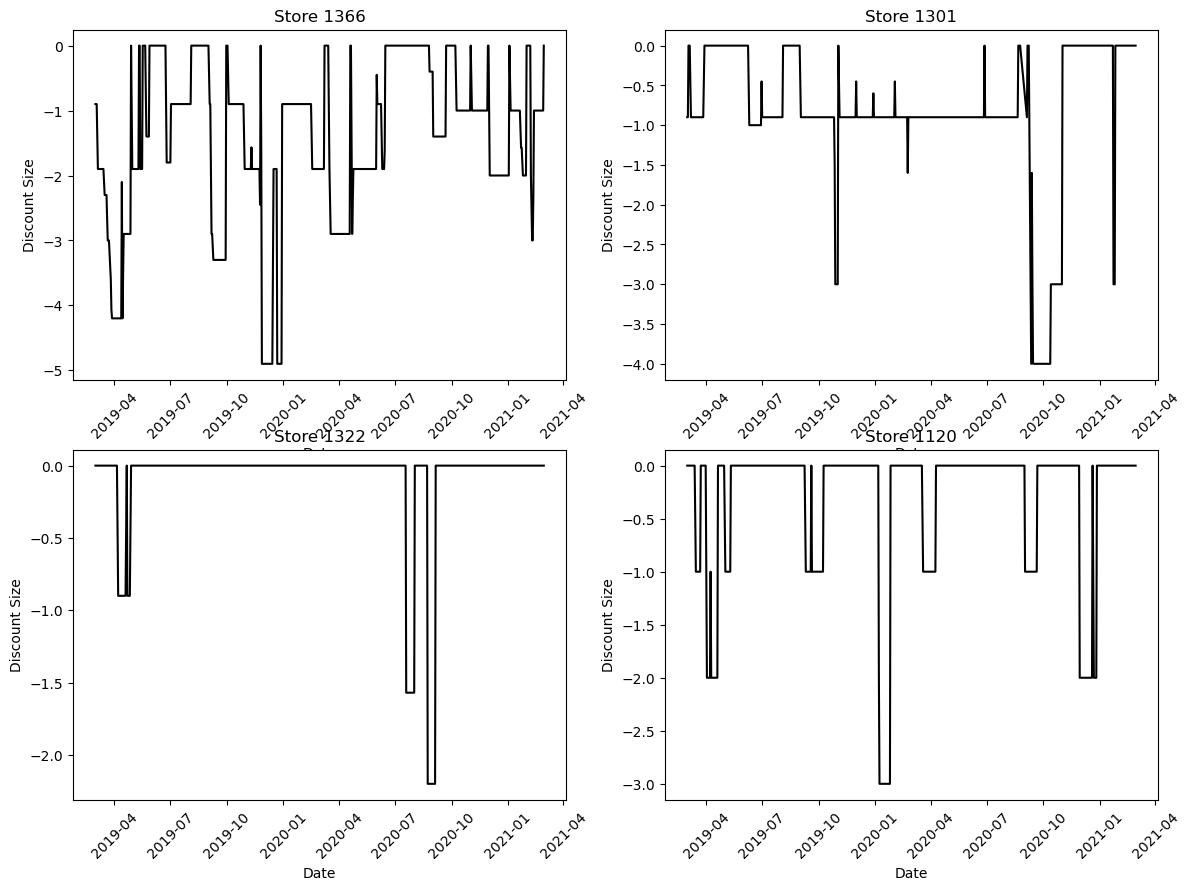

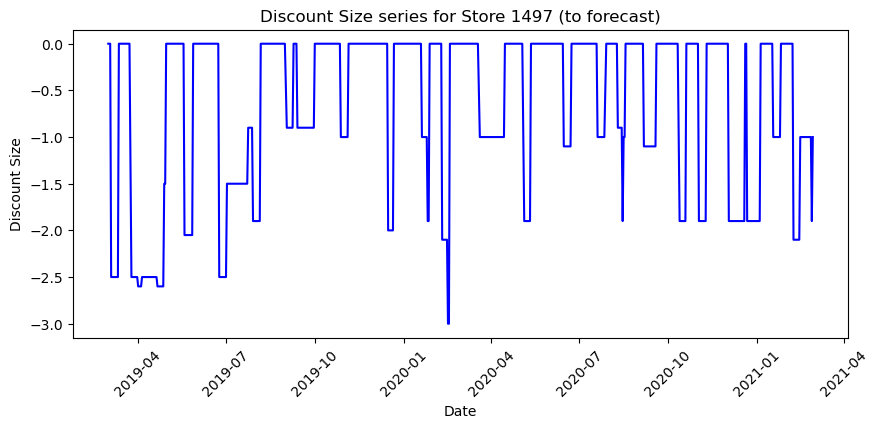

<Figure size 640x480 with 0 Axes>

In [4]:
# Plot the series for all stores
plt.figure(figsize=(14, 10))

for i, store_id in enumerate(store_ids):
    if store_id == store_to_forecast:
        plt.figure(figsize=(10, 4))
        plt.plot(data_dict[store_id]['Date'], data_dict[store_id][target_variable], color="blue")
        plt.title(f"Discount Size series for Store {store_id} (to forecast)")
        plt.xlabel('Date')
        plt.ylabel('Discount Size')
        plt.xticks(rotation=45)
        plt.show()
    else:
        plt.subplot(2, 2, i+1)
        plt.plot(data_dict[store_id]['Date'], data_dict[store_id][target_variable], color="black")
        plt.title(f"Store {store_id}")
        plt.xlabel('Date')
        plt.ylabel('Discount Size')
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Data preparation

In [5]:
# Scale the data
scaler = MinMaxScaler()
for store_id in store_ids:
    data_dict[store_id][target_variable] = scaler.fit_transform(data_dict[store_id][[target_variable]])

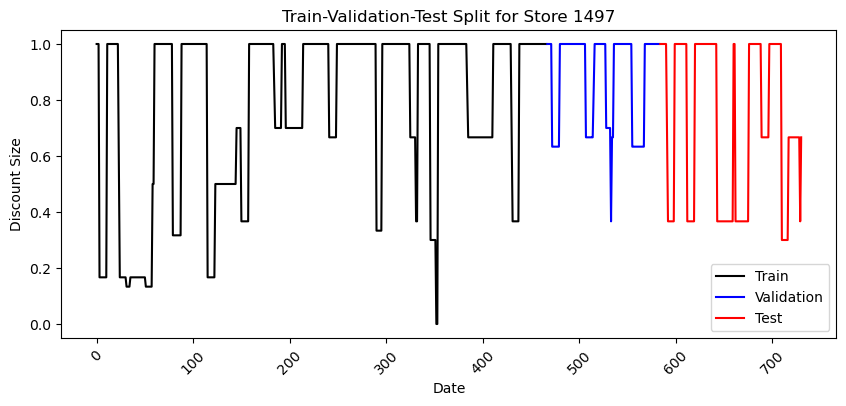

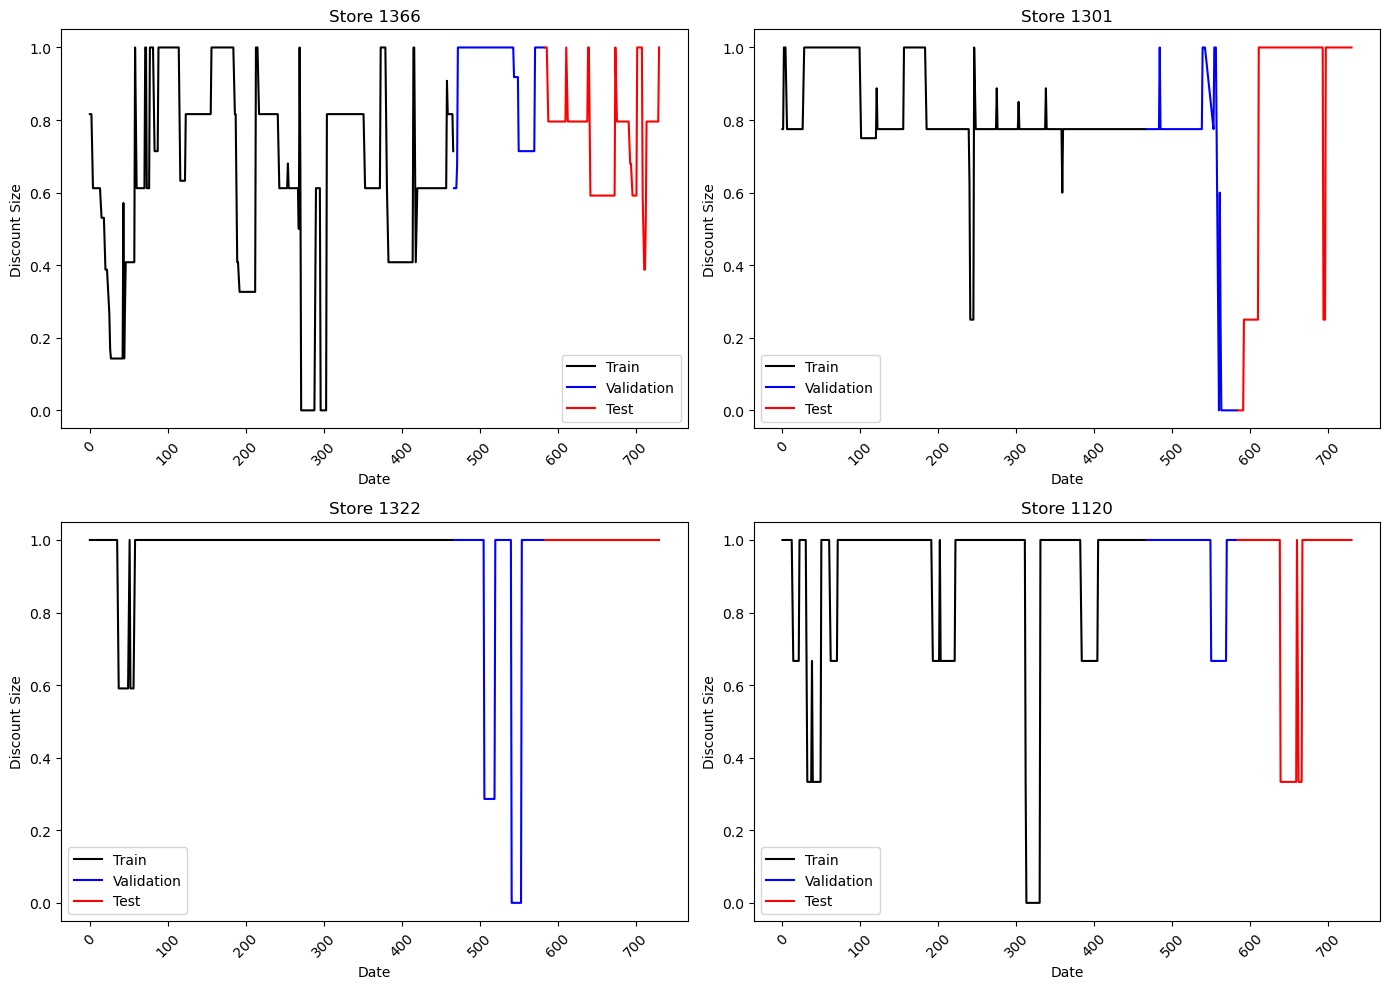

In [6]:
# Split into train and test sets and visualize
train_size_ratio = 0.8
train_dict = {}
validation_dict = {}
test_dict = {}

for store_id in store_ids:
    data = data_dict[store_id]
    train_size = int(len(data) * train_size_ratio * train_size_ratio)
    train_validation_size = int(len(data) * train_size_ratio)
    train, validation, test = data[target_variable][0:train_size], data[target_variable][train_size:train_validation_size], data[target_variable][train_validation_size:len(data)]
    train_dict[store_id] = train
    validation_dict[store_id] = validation
    test_dict[store_id] = test

# Plot the chosen store
plt.figure(figsize=(10, 4))
plt.plot(train_dict[store_to_forecast], color="black", label="Train")
plt.plot(range(len(train_dict[store_to_forecast]), len(train_dict[store_to_forecast]) + len(validation_dict[store_to_forecast])), validation_dict[store_to_forecast], color="blue", label="Validation")
plt.plot(range(len(train_dict[store_to_forecast]) + len(validation_dict[store_to_forecast]), len(train_dict[store_to_forecast]) + len(validation_dict[store_to_forecast]) + len(test_dict[store_id])), test_dict[store_to_forecast], color="red", label="Test")
plt.title(f"Train-Validation-Test Split for Store {store_to_forecast}")
plt.xlabel('Date')
plt.ylabel('Discount Size')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot the rest of the stores
plt.figure(figsize=(14, 10))
for i, store_id in enumerate(store_ids):
    if store_id != store_to_forecast:
        plt.subplot(2, 2, i+1)
        plt.plot(train_dict[store_id], color="black", label="Train")
        plt.plot(range(len(train_dict[store_id]), len(train_dict[store_id]) + len(validation_dict[store_id])), validation_dict[store_id], color="blue", label="Validation")
        plt.plot(range(len(train_dict[store_id]) + len(validation_dict[store_id]), len(train_dict[store_id]) + len(validation_dict[store_id]) + len(test_dict[store_id])), test_dict[store_id], color="red", label="Test")
        plt.title(f"Store {store_id}")
        plt.xlabel('Date')
        plt.ylabel('Discount Size')
        plt.legend()
        plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Prepare time series data
def prepare_time_series_data(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back)]
        dataX.append(a)
        dataY.append(data[i + look_back])
    return np.array(dataX), np.array(dataY)

trainX, trainY, validationX, validationY, testX, testY = {}, {}, {}, {}, {}, {}

for store_id in store_ids:
    train_data = train_dict[store_id].values
    validation_data = validation_dict[store_id].values
    test_data = test_dict[store_id].values

    trainX[store_id], trainY[store_id] = prepare_time_series_data(train_data, look_back)
    validationX[store_id], validationY[store_id] = prepare_time_series_data(validation_data, look_back)
    testX[store_id], testY[store_id] = prepare_time_series_data(test_data, look_back)

    # Reshape into [samples, time steps, features]
    trainX[store_id] = np.reshape(trainX[store_id], (trainX[store_id].shape[0], trainX[store_id].shape[1], 1))
    validationX[store_id] = np.reshape(validationX[store_id], (validationX[store_id].shape[0], validationX[store_id].shape[1], 1))
    testX[store_id] = np.reshape(testX[store_id], (testX[store_id].shape[0], testX[store_id].shape[1], 1))

    # Convert to TensorFlow tensors
    trainX[store_id] = tf.convert_to_tensor(trainX[store_id], dtype=tf.float32)
    trainY[store_id] = tf.convert_to_tensor(trainY[store_id], dtype=tf.float32)
    validationX[store_id] = tf.convert_to_tensor(validationX[store_id], dtype=tf.float32)
    validationY[store_id] = tf.convert_to_tensor(validationY[store_id], dtype=tf.float32)
    testX[store_id] = tf.convert_to_tensor(testX[store_id], dtype=tf.float32)
    testY[store_id] = tf.convert_to_tensor(testY[store_id], dtype=tf.float32)

### Define the multi-input model

First we will define the models that takes multiple inputs from different sub-models. Each store's time series data is processed by a separate neural network model, which learns the temporal patterns specific to that store.
The outputs of these neural network models are concatenated or joined in other ways, forming a single, comprehensive feature vector.
This feature vector is then fed into dense layers, allowing the model to learn complex interactions between the different stores' data.

In [8]:
# Define a function to create an RNN model, using LSTM for the store to forecast
def create_rnn_model(input_shape, store_id, store_to_forecast):
    model = Sequential()
    if store_id == store_to_forecast:
        model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
        model.add(LSTM(8, return_sequences=True))
    else:
        model.add(GRU(16, input_shape=input_shape, return_sequences=True))
        model.add(GRU(8, return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(4))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1))
    return model

# Create models for each store
input_shape = (look_back, 1)
models = {store_id: create_rnn_model(input_shape, store_id, store_to_forecast) for store_id in store_ids}

We will explore four different strategies for combining the outputs of individual sub-models

##### Concatenate method
In this method, the outputs from individual neural network models are concatenated together and then passed through dense layers to generate the final output. By concatenating the outputs, the model can learn interactions between the stores and unique patterns and relationships in each store's data.

In [9]:
def combined_model_concatenate(input_shape, look_back, store_ids):
    # Create input layers for each store
    inputs = {store_id: Input(shape=input_shape, name=f'input_{store_id}') for store_id in store_ids}
    # Get outputs from individual RNN models
    rnn_outputs = []
    for store_id in store_ids:
        rnn_model = create_rnn_model((look_back, 1), store_id, store_to_forecast)
        rnn_outputs.append(rnn_model(inputs[store_id]))

    # Combine outputs and add dense layers
    combined = tf.keras.layers.concatenate(rnn_outputs)
    dense1 = Dense(32, activation='relu')(combined)
    dense2 = Dense(16, activation='relu')(dense1)
    output = Dense(1)(dense2)

    # Create the final model
    model = Model(inputs=[inputs[store_id] for store_id in store_ids], outputs=output)
    return model

##### Average method
In this method, the outputs from individual RNN models are averaged together and then passed through dense layers to generate the final output. This method reduces the risk of overfitting to any single store's data by averaging the predictions. It ensures that the final prediction benefits from the collective wisdom of all the stores' NN models, potentially smoothing out noise and anomalies.

In [10]:
def combined_model_average(input_shape, look_back, store_ids):
    inputs = {store_id: Input(shape=input_shape, name=f'input_{store_id}') for store_id in store_ids}

    rnn_outputs = []
    for store_id in store_ids:
        rnn_model = create_rnn_model(input_shape, store_id, store_to_forecast)
        rnn_outputs.append(rnn_model(inputs[store_id]))

    combined = Average()(rnn_outputs)
    dense1 = Dense(32, activation='relu')(combined)
    dense2 = Dense(16, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[inputs[store_id] for store_id in store_ids], outputs=output)
    return model

##### Attention method
In this method, an attention mechanism is applied to the combined outputs of individual RNN models to generate the final output. The attention mechanism allows the model to focus on the most relevant stores for each prediction.

In [11]:
def combined_model_attention(input_shape, look_back, store_ids):
    inputs = {store_id: Input(shape=input_shape, name=f'input_{store_id}') for store_id in store_ids}

    rnn_outputs = []
    for store_id in store_ids:
        rnn_model = create_rnn_model(input_shape, store_id, store_to_forecast)
        rnn_outputs.append(rnn_model(inputs[store_id]))

    # Concatenate outputs to create a single tensor
    combined = Concatenate()(rnn_outputs)
    
    # Attention mechanism
    attention = Attention()([combined, combined])  # Using combined tensor as both query and value
    
    dense1 = Dense(32, activation='relu')(combined)
    dense2 = Dense(16, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[inputs[store_id] for store_id in store_ids], outputs=output)
    return model

##### Voting ensemble method
In this method, a voting ensemble approach is applied where the outputs from individual RNN models are averaged to generate the final output. This method is straightforward, leveraging the diversity of the individual NN models to improve the overall prediction.

In [12]:
def combined_model_voting(input_shape, look_back, store_ids):
    inputs = {store_id: Input(shape=input_shape, name=f'input_{store_id}') for store_id in store_ids}

    rnn_outputs = []
    for store_id in store_ids:
        rnn_model = create_rnn_model((look_back, 1), store_id, store_to_forecast)
        rnn_outputs.append(rnn_model(inputs[store_id]))

    combined = Lambda(lambda x: tf.reduce_mean(x, axis=0))(rnn_outputs)
    dense1 = Dense(32, activation='relu')(combined)
    dense2 = Dense(16, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[inputs[store_id] for store_id in store_ids], outputs=output)
    return model

In [13]:
# List of models and their names for comparison
models = [
    ('Concatenate', combined_model_concatenate),
    ('Average', combined_model_average),
    ('Attention', combined_model_attention),
    ('Voting Ensemble', combined_model_voting),
]

### Model Training and Evaluation

5/5 [==============================] - 0s 4ms/step
Concatenate: Train Score = 0.39 RMSE, Validation Score = 0.75 RMSE, Test Score = 0.50 RMSE


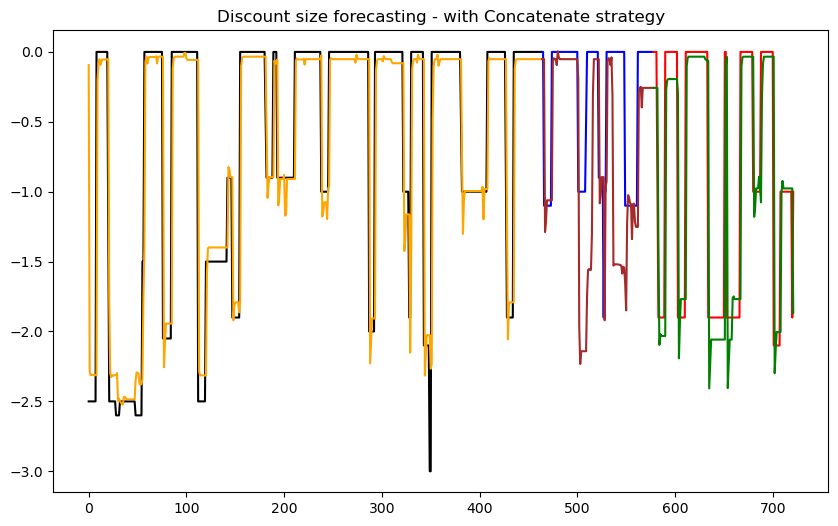

5/5 [==============================] - 0s 6ms/step
Average: Train Score = 0.40 RMSE, Validation Score = 0.94 RMSE, Test Score = 0.49 RMSE


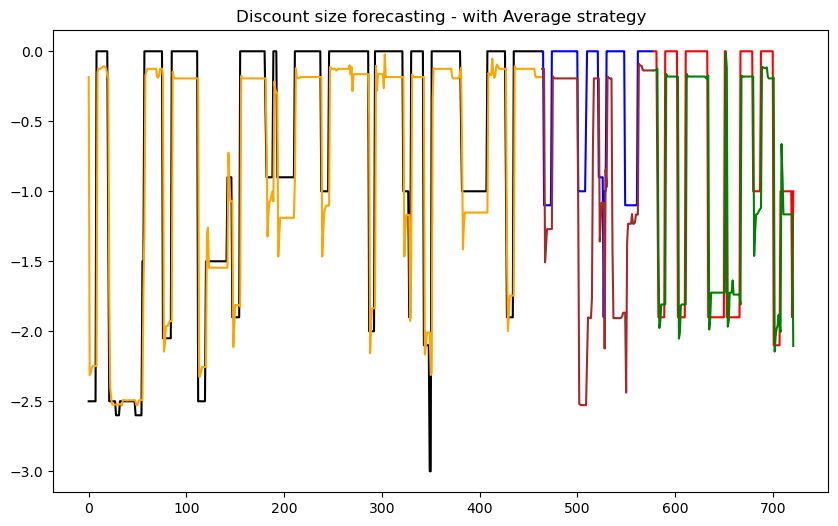

5/5 [==============================] - 0s 6ms/step
Attention: Train Score = 0.39 RMSE, Validation Score = 0.47 RMSE, Test Score = 0.49 RMSE


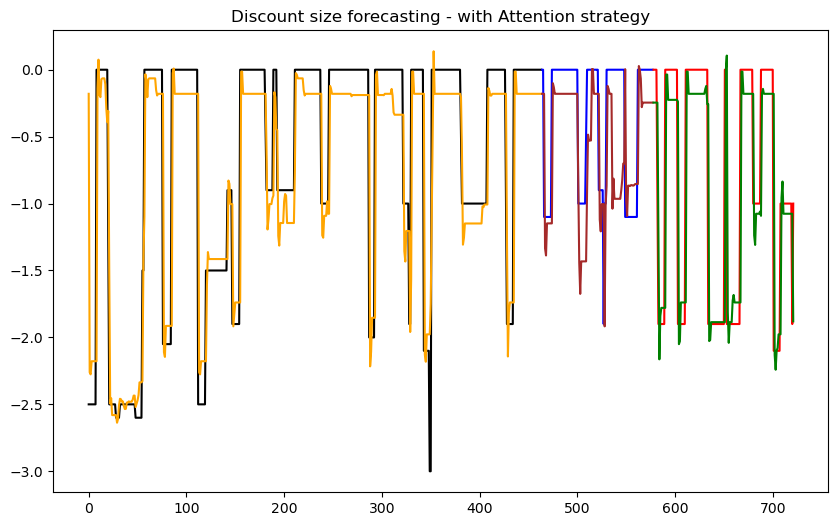

5/5 [==============================] - 0s 5ms/step
Voting Ensemble: Train Score = 0.39 RMSE, Validation Score = 0.55 RMSE, Test Score = 0.49 RMSE


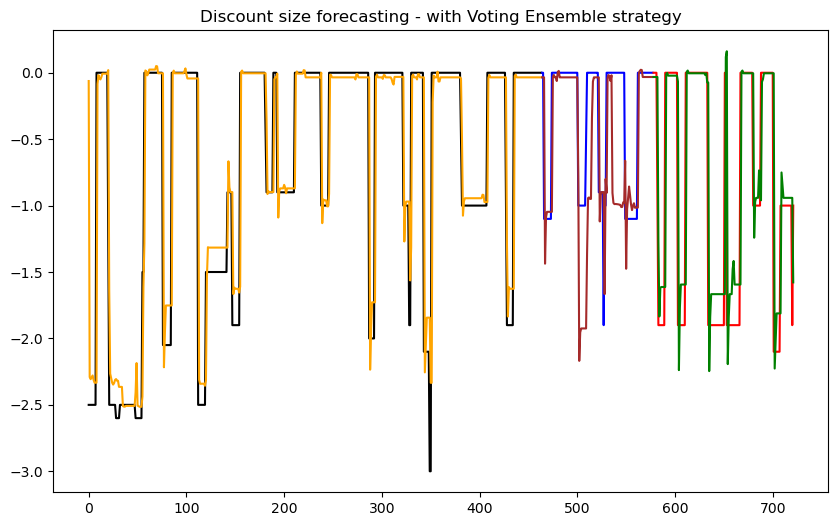

In [14]:
# Prepare inputs for the combined model
def prepare_combined_inputs(trainX, validationX, testX, store_ids):
    train_inputs = {f'input_{store_id}': trainX[store_id] for store_id in store_ids}
    validation_inputs = {f'input_{store_id}': validationX[store_id] for store_id in store_ids}
    test_inputs = {f'input_{store_id}': testX[store_id] for store_id in store_ids}
    return train_inputs, validation_inputs, test_inputs

# Training and evaluation loop
results = []
for name, model_func in models:
    # Create model
    model = model_func(input_shape, look_back, store_ids)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    train_inputs, validation_inputs, test_inputs = prepare_combined_inputs(trainX, validationX, testX, store_ids)
    train_targets = trainY[store_to_forecast]  # Target is the trainY of the main store
    validation_targets = validationY[store_to_forecast]  # Target is the validationY of the main store
    test_targets = testY[store_to_forecast]  # Target is the testY of the main store

    # Train model
    model.fit(train_inputs, train_targets, epochs=100, batch_size=32, validation_data=(validation_inputs, validation_targets), verbose=0)
    
    # Make predictions
    train_predictions = model.predict(train_inputs)
    validation_predictions = model.predict(validation_inputs)
    test_predictions = model.predict(test_inputs)
    
    # Invert predictions
    train_predictions = scaler.inverse_transform(train_predictions)
    orig_trainY = scaler.inverse_transform(train_targets.numpy().reshape(-1, 1))
    validation_predictions = scaler.inverse_transform(validation_predictions)
    orig_validationY = scaler.inverse_transform(validation_targets.numpy().reshape(-1, 1))
    test_predictions = scaler.inverse_transform(test_predictions)
    orig_testY = scaler.inverse_transform(test_targets.numpy().reshape(-1, 1))
    
    # Calculate root mean squared error
    train_score = np.sqrt(mean_squared_error(orig_trainY, train_predictions))
    validation_score = np.sqrt(mean_squared_error(orig_validationY, validation_predictions))
    test_score = np.sqrt(mean_squared_error(orig_testY, test_predictions))
    
    results.append((name, train_score, test_score))
    print(f'{name}: Train Score = {train_score:.2f} RMSE, Validation Score = {validation_score:.2f} RMSE, Test Score = {test_score:.2f} RMSE')
    
    # Plot the predictions
    train_length = len(orig_trainY)
    x_validation = range(train_length, train_length + len(orig_validationY))
    x_test = range(train_length + len(orig_validationY), train_length + len(orig_validationY) + len(orig_testY))

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(orig_trainY)), orig_trainY, label='Train original', color="black")
    plt.plot(range(len(train_predictions)), train_predictions, label='Train predicted', color="orange")
    plt.plot(x_validation, orig_validationY, label='Test original', color="blue")
    plt.plot(x_validation, validation_predictions, label='Test predicted', color="brown")
    plt.plot(x_test, orig_testY, label='Test original', color="red")
    plt.plot(x_test, test_predictions, label='Test predicted', color="green")
    plt.title(f'Discount size forecasting - with {name} strategy')
    plt.show()

Overall, the attention method presents promising performance for the discount size forecasting task.